In [1]:
import ROOT
import uproot
import awkward as ak
import os
from timeit import Timer
import matplotlib.pyplot as plt
import pandas as pd

Welcome to JupyROOT 6.22/06


In [2]:
def benchmark_uproot(filename):
    with uproot.open(f"{filename}:tree") as tree:
        return {
            k : v.array(
                decompression_executor=uproot.source.futures.TrivialExecutor(),
                interpretation_executor=uproot.source.futures.TrivialExecutor(),
            )
            for k, v in tree.iteritems()
        }

In [3]:
base_dir = "/home/nikolai/data/user.nihartma.physlite_test_ttbar_split99.001_EXT0"

In [4]:
rf = ROOT.TFile.Open(os.path.join(base_dir, "physlite_flat_10000.root"))
rt = rf.Get("tree")
rt.MakeClass("test_class")
rf.Close()

Info in <TTreePlayer::MakeClass>: Files: test_class.h and test_class.C generated from TTree: tree


In [5]:
ROOT.gInterpreter.ProcessLine(".L test_class.C+")

0

Info in <TUnixSystem::ACLiC>: creating shared library /home/nikolai/code/physlite_experiments/notebooks/test_class_C.so


In [6]:
def benchmark_root(filename):
    rf = ROOT.TFile.Open(filename)
    rt = rf.Get("tree")
    selector = ROOT.test_class(rt)
    selector.Loop()
    rf.Close()

In [7]:
%time benchmark_root(os.path.join(base_dir, "physlite_flat_10000.root"))

CPU times: user 5.38 s, sys: 521 ms, total: 5.9 s
Wall time: 5.94 s


In [8]:
%time benchmark_root(os.path.join(base_dir, "physlite_flat_lz4_10000.root"))

CPU times: user 4.07 s, sys: 231 ms, total: 4.3 s
Wall time: 4.29 s


In [9]:
%time ar = benchmark_uproot(os.path.join(base_dir, "physlite_flat_lz4_10000.root"))

CPU times: user 2.63 s, sys: 101 ms, total: 2.73 s
Wall time: 2.73 s


In [10]:
times = []
for nentries in [1250, 2500, 5000, 10000]:
    d = {"nentries" : nentries}
    for k, f in [("root", benchmark_root), ("uproot", benchmark_uproot)]:
        for lz4 in ["", "_lz4"]:
            print(nentries, k, lz4, f)
            d[k+lz4] = Timer(
                lambda: f(os.path.join(base_dir, f"physlite_flat{lz4}_{nentries}.root"))
            ).repeat(number=1, repeat=5)
    times.append(d)

1250 root  <function benchmark_root at 0x7fc8b5a27700>
1250 root _lz4 <function benchmark_root at 0x7fc8b5a27700>
1250 uproot  <function benchmark_uproot at 0x7fc8b5a274c0>
1250 uproot _lz4 <function benchmark_uproot at 0x7fc8b5a274c0>
2500 root  <function benchmark_root at 0x7fc8b5a27700>
2500 root _lz4 <function benchmark_root at 0x7fc8b5a27700>
2500 uproot  <function benchmark_uproot at 0x7fc8b5a274c0>
2500 uproot _lz4 <function benchmark_uproot at 0x7fc8b5a274c0>
5000 root  <function benchmark_root at 0x7fc8b5a27700>
5000 root _lz4 <function benchmark_root at 0x7fc8b5a27700>
5000 uproot  <function benchmark_uproot at 0x7fc8b5a274c0>
5000 uproot _lz4 <function benchmark_uproot at 0x7fc8b5a274c0>
10000 root  <function benchmark_root at 0x7fc8b5a27700>
10000 root _lz4 <function benchmark_root at 0x7fc8b5a27700>
10000 uproot  <function benchmark_uproot at 0x7fc8b5a274c0>
10000 uproot _lz4 <function benchmark_uproot at 0x7fc8b5a274c0>


In [11]:
df = pd.DataFrame([{k : min(v) if isinstance(v, list) else v for k, v in d.items()} for d in times])

In [12]:
def benchmark_parquet(filename):
    return ak.from_parquet(filename)

In [13]:
%time ar = benchmark_parquet(os.path.join(base_dir, "physlite_1250.parquet"))

CPU times: user 548 ms, sys: 79.8 ms, total: 628 ms
Wall time: 466 ms


In [14]:
parquet_times = []
for nentries in [1250, 2500, 5000, 10000]:
    print(nentries)
    parquet_times.append(
        Timer(
            lambda: benchmark_parquet(os.path.join(base_dir, f"physlite_{nentries}.parquet"))
        ).repeat(number=1, repeat=5)
    )

1250
2500
5000
10000


In [15]:
df["parquet"] = [min(t) for t in parquet_times]

<AxesSubplot:xlabel='nentries'>

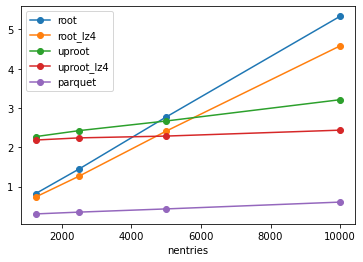

In [16]:
df.plot(x="nentries", marker="o")

Text(0, 0.5, 'Time [s]')

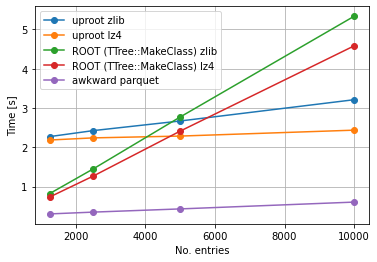

In [17]:
def plot(df, ax=None):
    ax = ax or plt.gca()
    x = df.index
    ax.plot(x, df.uproot, "o-", label="uproot zlib")
    ax.plot(x, df.uproot_lz4, "o-", label="uproot lz4")
    ax.plot(x, df.root, "o-", label="ROOT (TTree::MakeClass) zlib")
    ax.plot(x, df.root_lz4, "o-", label="ROOT (TTree::MakeClass) lz4")
    ax.plot(x, df.parquet, "o-", label="awkward parquet")
    ax.grid()
    ax.legend()
    return ax
fig, ax = plt.subplots()
ax = plot(df.set_index("nentries"), ax=ax)
ax.set_xlabel("No. entries")
ax.set_ylabel("Time [s]")
#fig.savefig("parquet_vs_root_vs_uproot.pdf")

Text(0, 0.5, 'Time (relative to first) [s]')

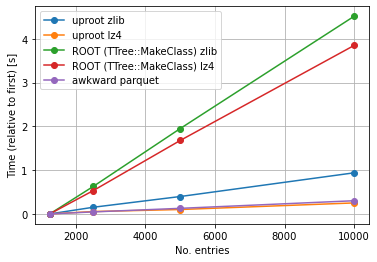

In [18]:
fig, ax = plt.subplots()
dfn = df.set_index("nentries")
dfn = (dfn - dfn.iloc[0])
plot(dfn, ax=ax)
ax.set_xlabel("No. entries")
ax.set_ylabel("Time (relative to first) [s]")
#fig.savefig("parquet_vs_root_vs_uproot_relative.pdf")

In [19]:
nentries_list = [1250, 2500, 5000, 10000]
parquet_sizes = [
    os.stat(os.path.join(base_dir, f"physlite_{nentries}.parquet")).st_size
    for nentries in nentries_list
]
root_sizes = [
    os.stat(os.path.join(base_dir, f"physlite_flat_{nentries}.root")).st_size
    for nentries in nentries_list
]
root_sizes_lz4 = [
    os.stat(os.path.join(base_dir, f"physlite_flat_lz4_{nentries}.root")).st_size
    for nentries in nentries_list
]

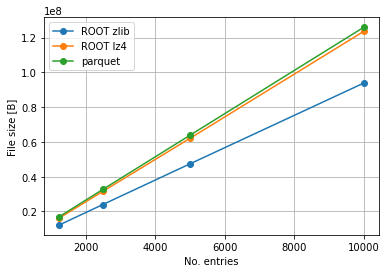

In [20]:
plt.plot(nentries_list, root_sizes, "o-", label="ROOT zlib")
plt.plot(nentries_list, root_sizes_lz4, "o-", label="ROOT lz4")
plt.plot(nentries_list, parquet_sizes, "o-", label="parquet")
plt.grid()
plt.xlabel("No. entries")
plt.ylabel("File size [B]")
plt.legend()
#plt.savefig("file_sizes.pdf")